In [1]:
import os
import numpy as np
import pandas as pd

from unidecode import unidecode

import tensorflow as tf
from tensorflow import keras

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from keras.layers import Dropout, Activation, Flatten, Convolution1D, Dropout, Reshape
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
#Define learning rate
lr=0.0001 

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [5]:
!nvidia-smi

Mon Dec 23 16:42:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   55C    P8             20W /  200W |    1354MiB /   8192MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import pandas as pd
import glob

path = r'H:/Datasets/CICIDS-2017/MachineLearningCVE' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, encoding='cp1252', index_col=None, header=0, low_memory=False)
    li.append(df)
    print("Read Completed for ", filename)
    
print("Reading Finished")
df = pd.concat(li, axis=0, ignore_index=True)

df = df.rename(columns={' Label': 'Label'})

Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
Read Completed for  H:/Datasets/CICIDS-2017/MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv
Reading Finished


In [7]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [8]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
import re

# Function to clean the labels
def clean_label(label):
    # Replace non-ASCII characters with a hyphen
    label = re.sub(r'[^\x00-\x7F]+', '-', label)
    return label.strip()  # Optional: Strip leading and trailing whitespace

# Apply the function to the DataFrame
df['Label'] = df['Label'].apply(clean_label)


df["Label"].value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack - Brute Force         1507
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

In [10]:
print(df.shape)

(2830743, 79)


In [11]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

<Figure size 2000x2000 with 0 Axes>

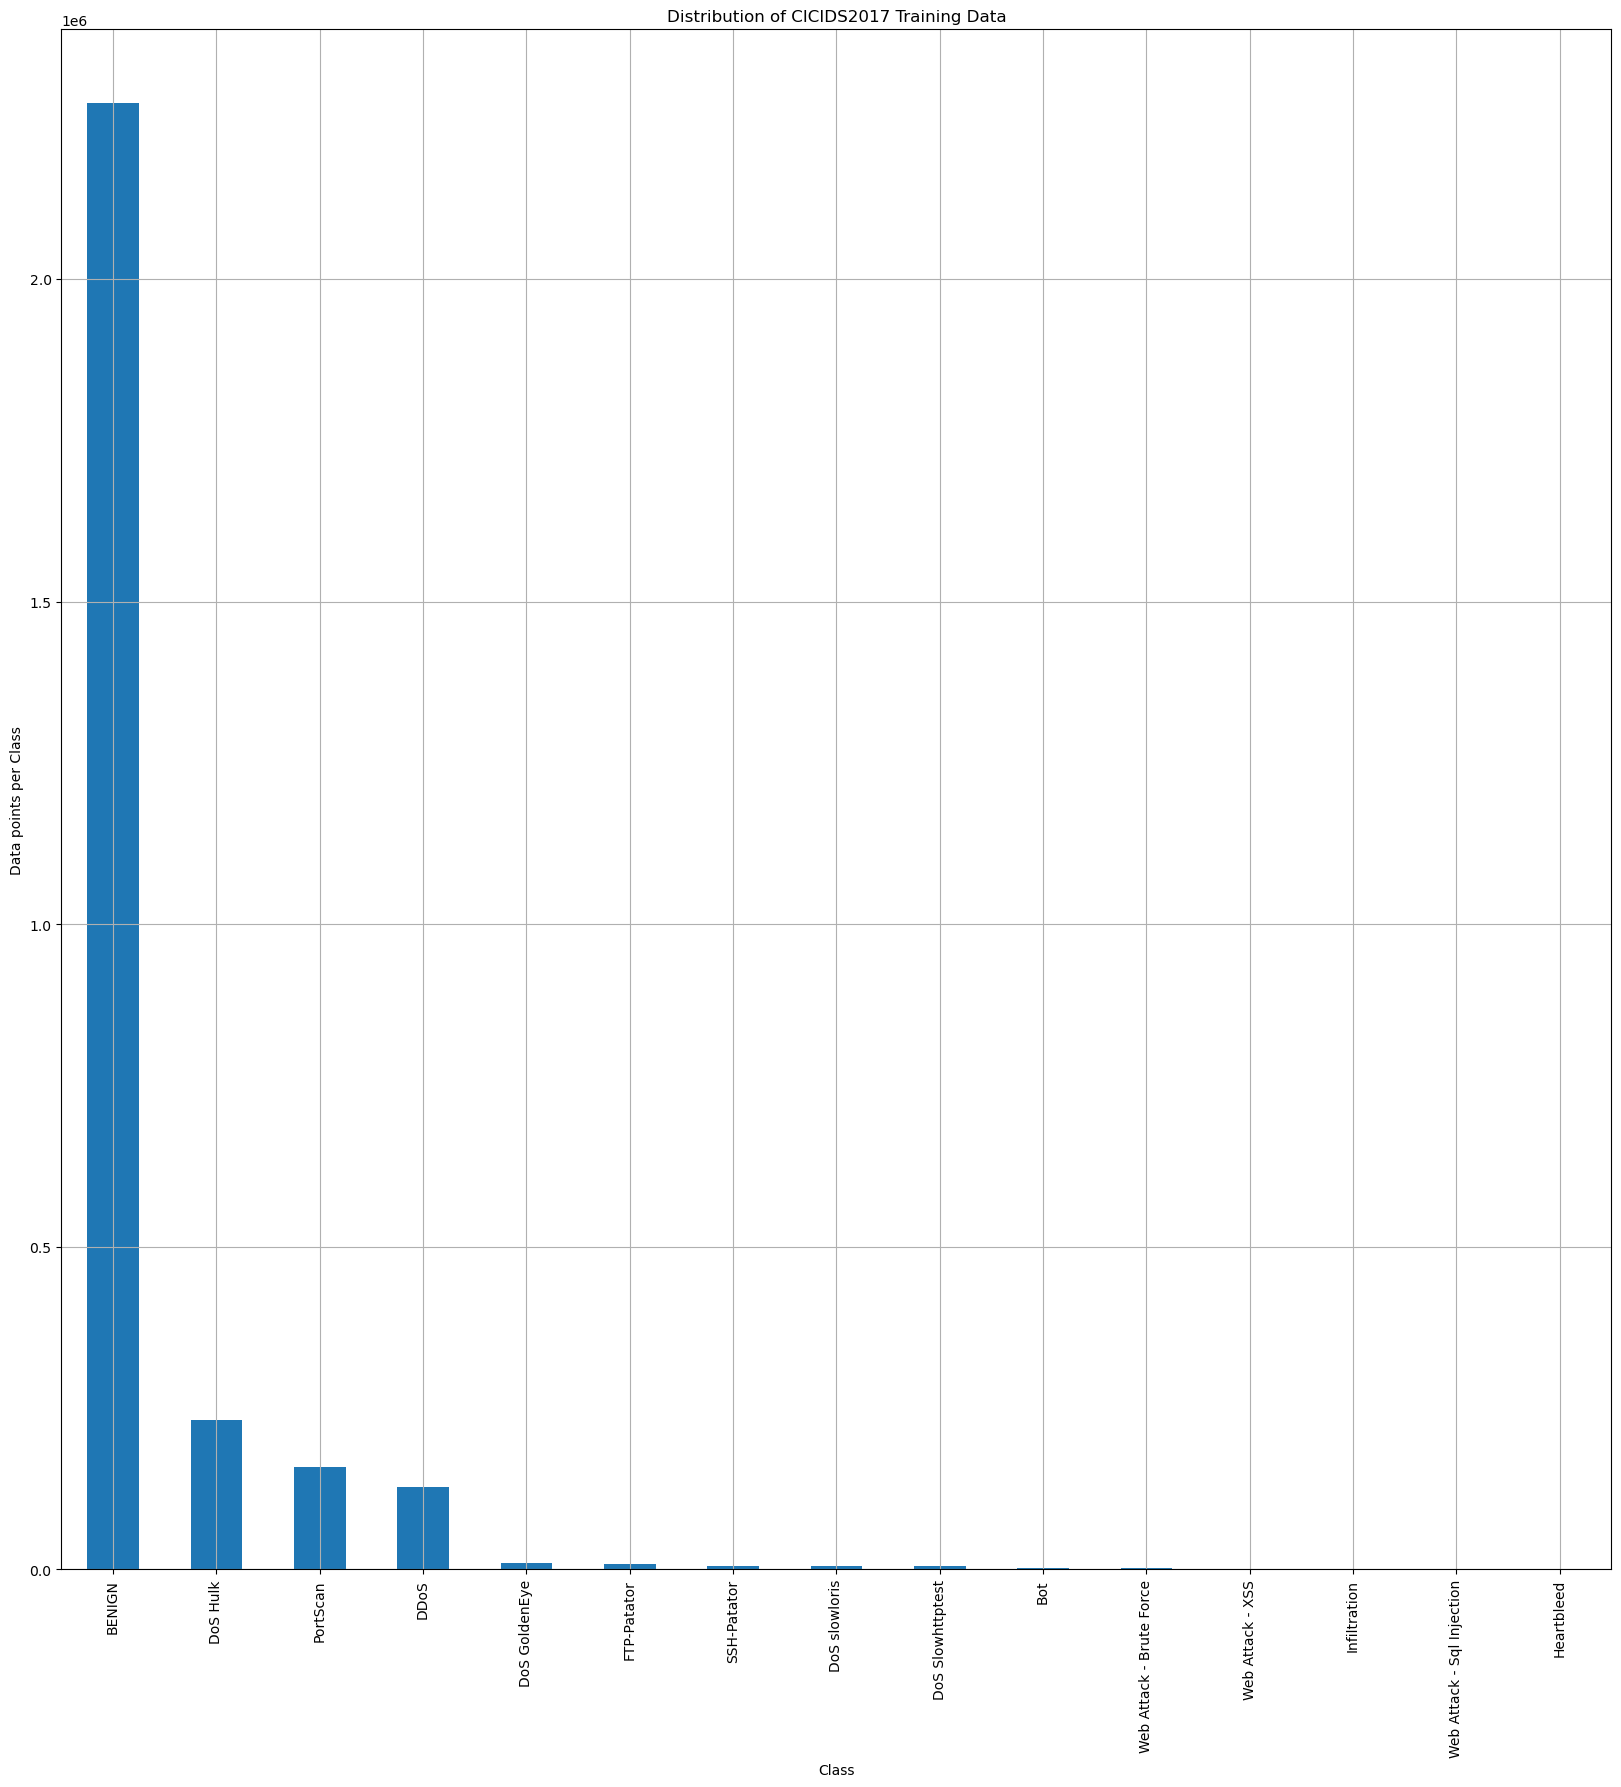

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(20,20))

fig, ax = plt.subplots(figsize=(20,20))
class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of CICIDS2017 Training Data')
plt.grid()
plt.show()

fig.savefig('CIC-IDS2017_Data_Distribution.pdf') 

In [13]:
# Before Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class BENIGN : 2273097 ( 80.3 %)
Number of data points in class DoS Hulk : 231073 ( 8.163 %)
Number of data points in class PortScan : 158930 ( 5.614 %)
Number of data points in class DDoS : 128027 ( 4.523 %)
Number of data points in class DoS GoldenEye : 10293 ( 0.364 %)
Number of data points in class FTP-Patator : 7938 ( 0.28 %)
Number of data points in class SSH-Patator : 5897 ( 0.208 %)
Number of data points in class DoS slowloris : 5796 ( 0.205 %)
Number of data points in class DoS Slowhttptest : 5499 ( 0.194 %)
Number of data points in class Bot : 1966 ( 0.069 %)
Number of data points in class Web Attack - Brute Force : 1507 ( 0.053 %)
Number of data points in class Web Attack - XSS : 652 ( 0.023 %)
Number of data points in class Infiltration : 36 ( 0.001 %)
Number of data points in class Web Attack - Sql Injection : 21 ( 0.001 %)
Number of data points in class Heartbleed : 11 ( 0.0 %)


In [14]:
del sorted_ds

#drop na values and reset index
data_clean = df.dropna().reset_index()

# Checkng for DUPLICATE values
data_clean.drop_duplicates(keep='first', inplace = True)

data_clean['Label'].value_counts()

print("Read {} rows.".format(len(data_clean)))

Read 2829385 rows.


In [15]:
analyze(data_clean)


2829385 rows
** index:2829385 (100%)
**  Destination Port:53804 (1%)
**  Flow Duration:1050899 (37%)
**  Total Fwd Packets:1432 (0%)
**  Total Backward Packets:1747 (0%)
** Total Length of Fwd Packets:17928 (0%)
**  Total Length of Bwd Packets:64698 (2%)
**  Fwd Packet Length Max:5279 (0%)
**  Fwd Packet Length Min:384 (0%)
**  Fwd Packet Length Mean:99716 (3%)
**  Fwd Packet Length Std:253909 (8%)
** Bwd Packet Length Max:4838 (0%)
**  Bwd Packet Length Min:583 (0%)
**  Bwd Packet Length Mean:147614 (5%)
**  Bwd Packet Length Std:248869 (8%)
** Flow Bytes/s:1593908 (56%)
**  Flow Packets/s:1240164 (43%)
**  Flow IAT Mean:1166311 (41%)
**  Flow IAT Std:1056642 (37%)
**  Flow IAT Max:580289 (20%)
**  Flow IAT Min:136316 (4%)
** Fwd IAT Total:493098 (17%)
**  Fwd IAT Mean:737737 (26%)
**  Fwd IAT Std:700313 (24%)
**  Fwd IAT Max:437316 (15%)
**  Fwd IAT Min:110631 (3%)
** Bwd IAT Total:414928 (14%)
**  Bwd IAT Mean:670824 (23%)
**  Bwd IAT Std:709042 (25%)
**  Bwd IAT Max:368285 (13%)
*

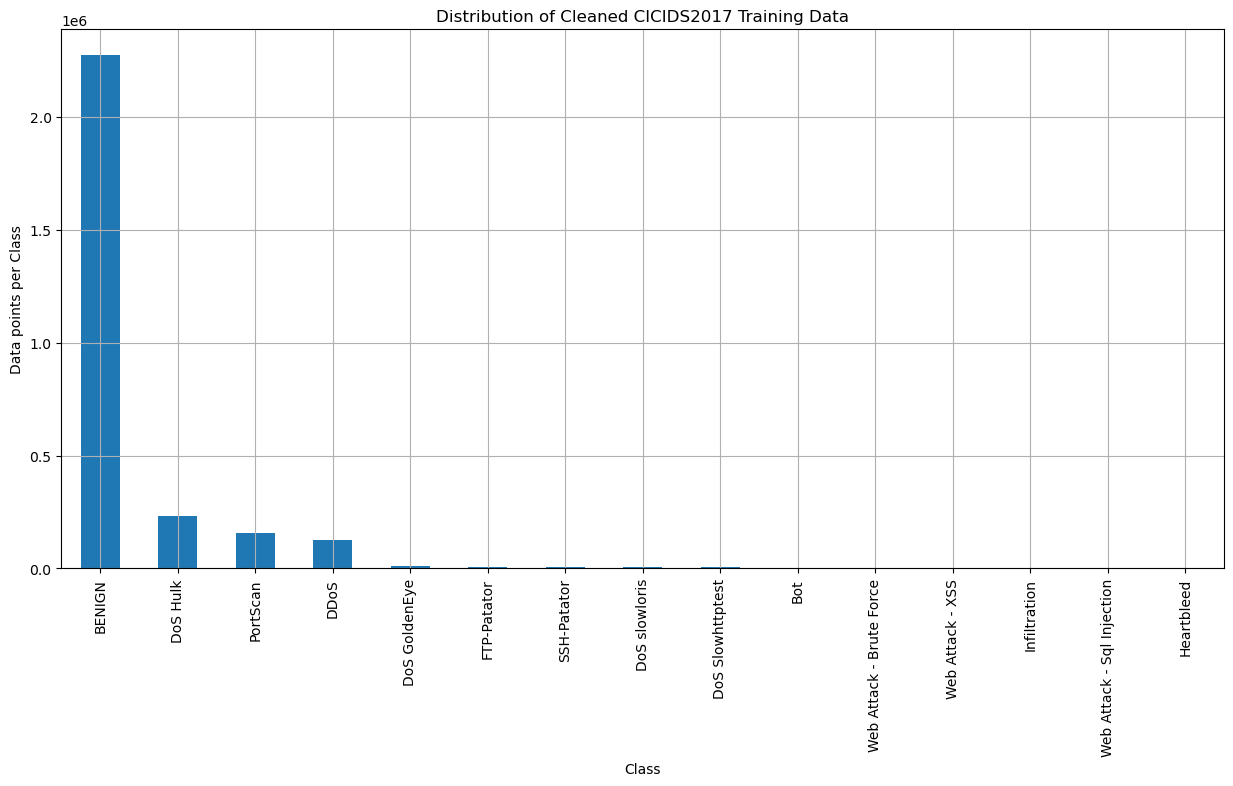

In [16]:
plt.figure(figsize=(15,7))
class_distribution = data_clean['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CICIDS2017 Training Data')
plt.grid()
plt.show()

In [17]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/data_clean.shape[0]*100), 3), '%)')

Number of data points in class BENIGN : 2272688 ( 80.324 %)
Number of data points in class DoS Hulk : 230124 ( 8.133 %)
Number of data points in class PortScan : 158930 ( 5.617 %)
Number of data points in class DDoS : 128027 ( 4.525 %)
Number of data points in class DoS GoldenEye : 10293 ( 0.364 %)
Number of data points in class FTP-Patator : 7938 ( 0.281 %)
Number of data points in class SSH-Patator : 5897 ( 0.208 %)
Number of data points in class DoS slowloris : 5796 ( 0.205 %)
Number of data points in class DoS Slowhttptest : 5499 ( 0.194 %)
Number of data points in class Bot : 1966 ( 0.069 %)
Number of data points in class Web Attack - Brute Force : 1507 ( 0.053 %)
Number of data points in class Web Attack - XSS : 652 ( 0.023 %)
Number of data points in class Infiltration : 36 ( 0.001 %)
Number of data points in class Web Attack - Sql Injection : 21 ( 0.001 %)
Number of data points in class Heartbleed : 11 ( 0.0 %)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder



#drop na values and reset index
data_clean = data_clean.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

0     2272688
4      230124
10     158930
2      128027
3       10293
7        7938
11       5897
6        5796
5        5499
1        1966
12       1507
14        652
9          36
13         21
8          11
Name: Label, dtype: int64

In [19]:
print(data_clean.shape)

(2829385, 81)


In [20]:
data_np = data_clean.to_numpy(dtype="float32")

#drop inf values
data_np = data_np[~np.isinf(data_np).any(axis=1)]

# Separate features (X) and target (Y)
X = data_np[:, :-1]  # All columns except the last one
enc = OneHotEncoder()
Y = enc.fit_transform(data_np[:, -1:]).toarray()  # One-hot encode the last column (target)

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

print('X.shape = ',X.shape)
print('Y.shape = ',Y.shape)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',Y_test.shape)

X.shape =  (2827876, 80)
Y.shape =  (2827876, 15)
X_train.shape =  (2120907, 80)
y_train.shape =  (2120907, 15)
X_test.shape =  (706969, 80)
y_test.shape =  (706969, 15)


In [22]:
print("X Shape: ", X.shape)
print("Y Shape: ", Y.shape)

X Shape:  (2827876, 80)
Y Shape:  (2827876, 15)


In [23]:
data = df.iloc[:,1:-1]

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [25]:
corr = data.corr()

<AxesSubplot:>

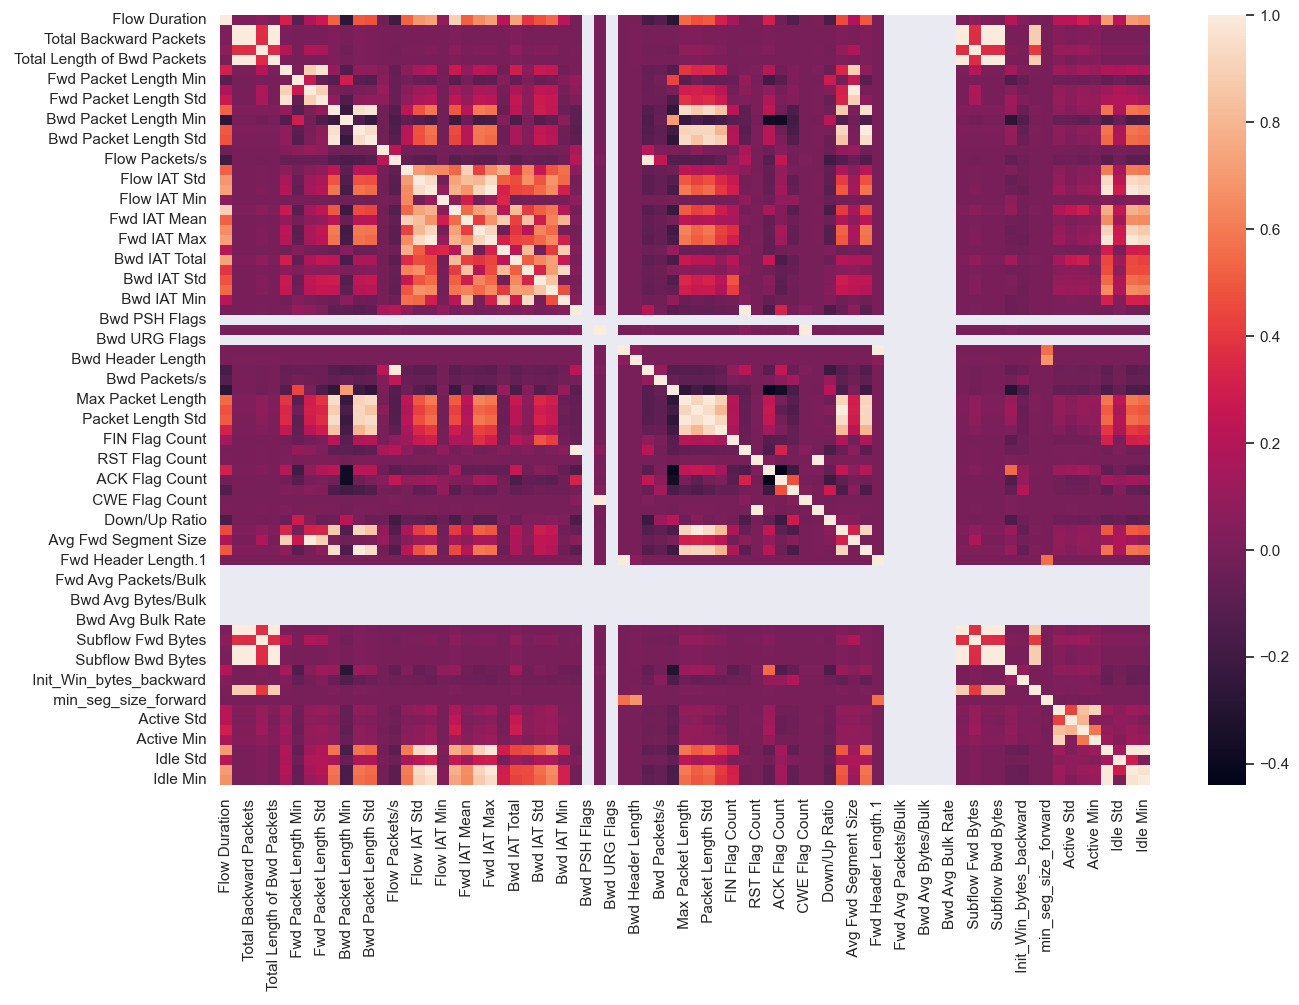

In [26]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr)

# IO-DCNN

In [27]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 75, 128)           896       
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 96)            73824     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 96)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 65, 64)            36928     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 65, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4160)              0

In [28]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

22093/22093 [==============================] - 33s 1ms/step
Best loss: 0.003308627987280488
Balanced Acc loss: 87.25608595875714
Learning Rate - 
1e-04


In [29]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

22093/22093 [==============================] - 35s 2ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:01:39.877444
Number of Batches: 5524.0
Time per Batch (Inference): 0.007373 seconds
Detection Time per Sample: 0.000058 seconds
Time for fitting: 40.73 seconds
Validation score: 0.9992800250081687
Evaluation score: [0.003308360232040286, 0.9992800354957581]
Recall score: 0.9992800250081687
Precision score: 0.9992859935354755
F1 Measure score: 0.999253865079485
ROC-AUC score: 0.936194900798768


In [30]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [31]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

22093/22093 [==============================] - 31s 1ms/step


In [32]:
pred.shape
y_test.shape

(706969,)

In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[567641,      1,     13,     11,     17,      6,      0,     14,
             0,      1,      5,      8,     42,      0,      9],
       [   171,    308,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     7,      0,  32112,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     5,      0,      0,   2568,     14,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [    68,      0,      0,      0,  57379,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     7,      0,      0,      1,      0,   1348,      5,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     5,      0,      0,      1,      0,     14,   1419,      0,
             0,      0,      0,      1,      0,      0,      0],
       [     6,      0,      0,      0,  

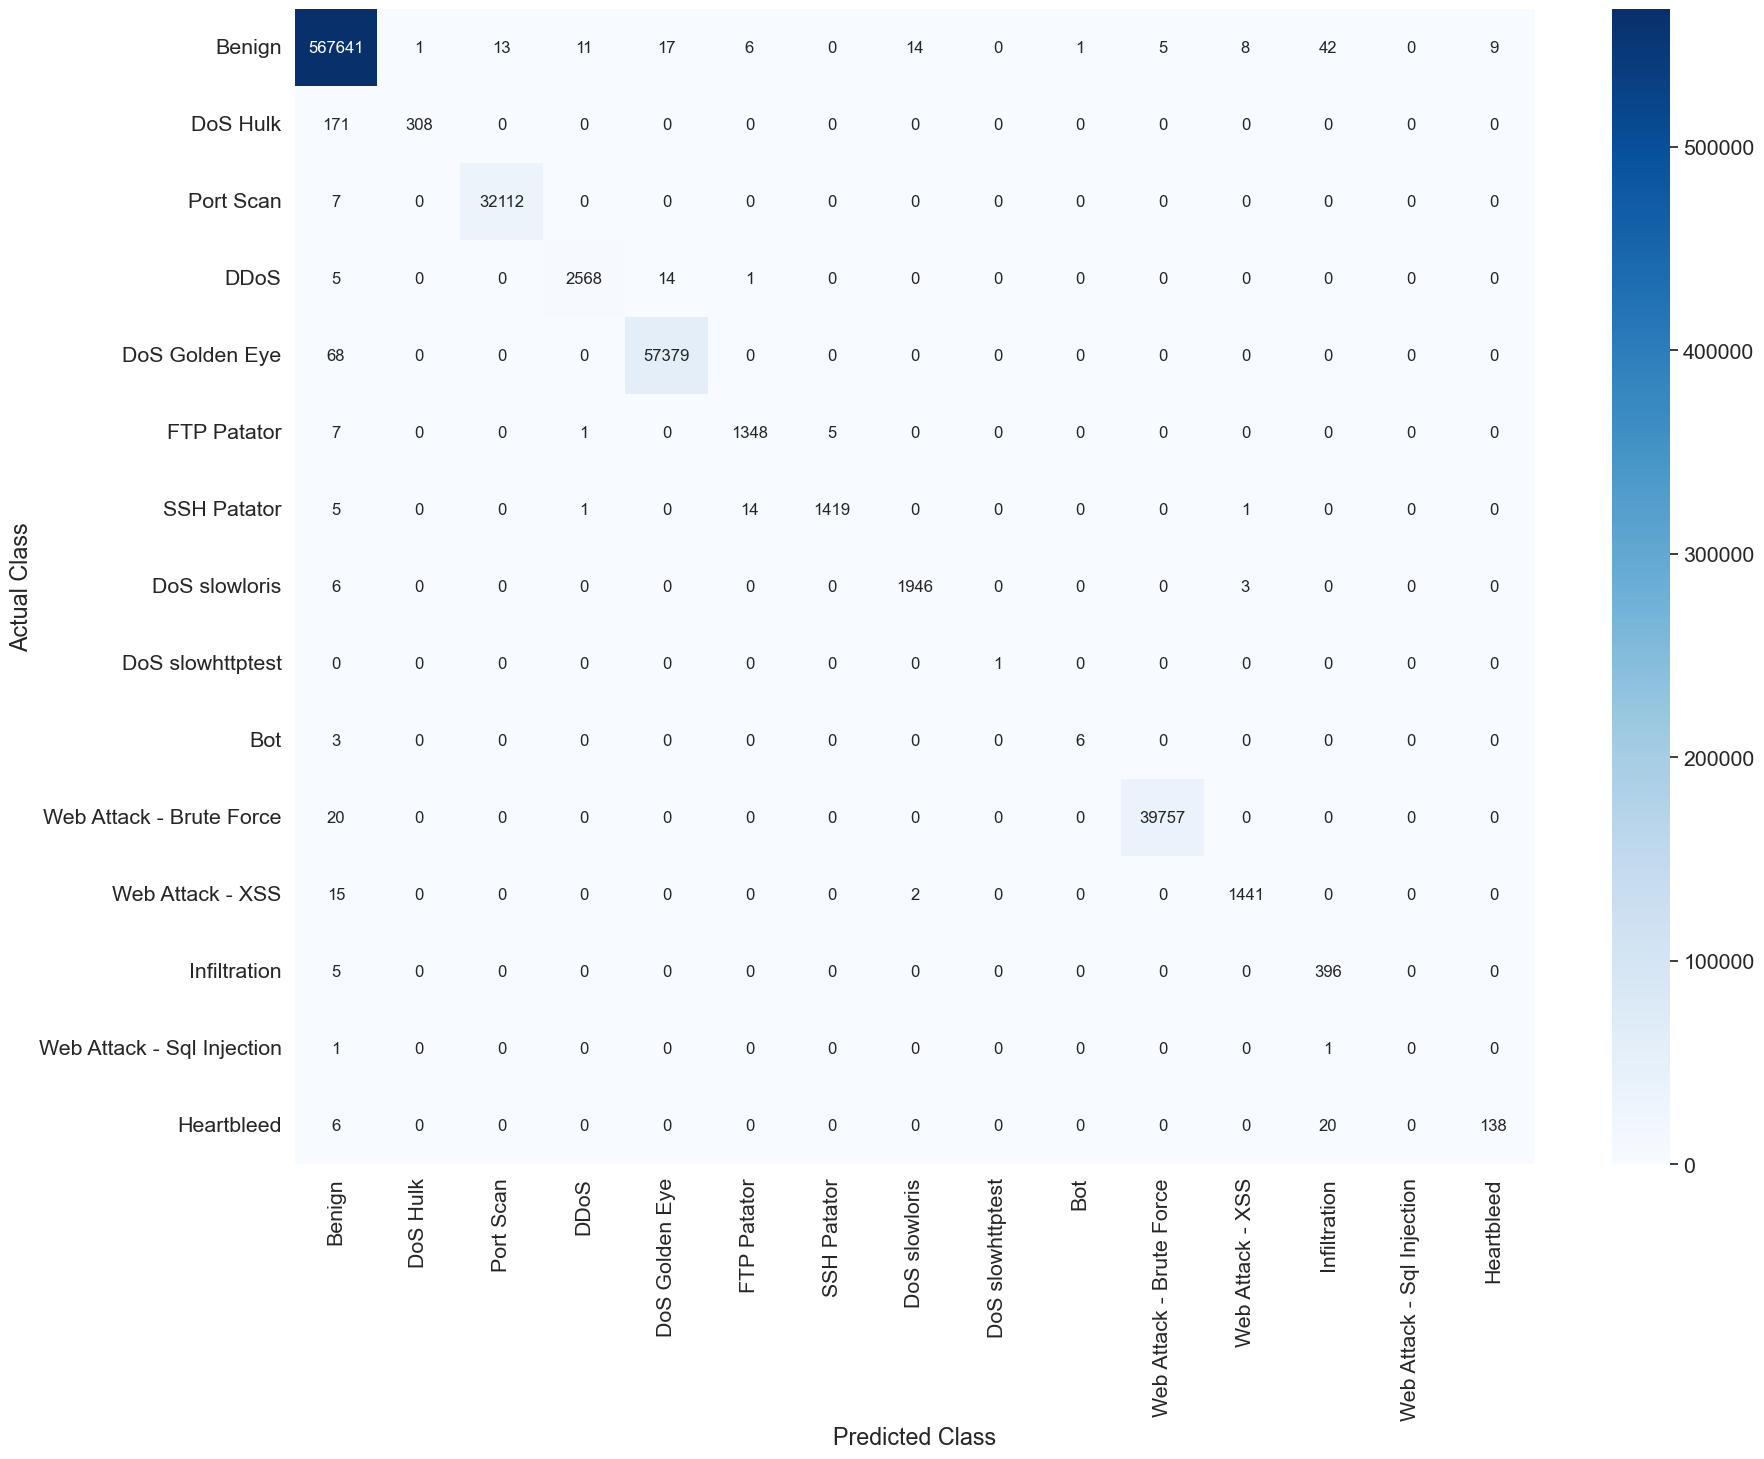

In [34]:
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['Benign','DoS Hulk','Port Scan','DDoS','DoS Golden Eye','FTP Patator','SSH Patator','DoS slowloris',
          'DoS slowhttptest','Bot','Web Attack - Brute Force','Web Attack - XSS','Infiltration','Web Attack - Sql Injection',
         'Heartbleed']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

# IO-DCNN - Adagrad

In [35]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adagrad(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 75, 128)           896       
                                                                 
 conv1d_4 (Conv1D)           (None, 70, 96)            73824     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 70, 96)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 65, 64)            36928     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 65, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4160)             

In [36]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

22093/22093 [==============================] - 30s 1ms/step
Best loss: 0.15778471529483795
Balanced Acc loss: 35.84590024534823
Learning Rate - 
1e-04


In [37]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

22093/22093 [==============================] - 30s 1ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:01:26.232858
Number of Batches: 5524.0
Time per Batch (Inference): 0.006520 seconds
Detection Time per Sample: 0.000051 seconds
Time for fitting: 36.02 seconds
Validation score: 0.9461673708465294
Evaluation score: [0.15778766572475433, 0.9461673498153687]
Recall score: 0.9461673708465294
Precision score: 0.9429963513813439
F1 Measure score: 0.9420784724482044
ROC-AUC score: 0.6728105078356219


In [38]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

22093/22093 [==============================] - 30s 1ms/step


In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[555402,      0,    895,     42,   1105,    167,      0,      0,
             0,      0,  10157,      0,      0,      0,      0],
       [   359,      0,      0,      0,      0,      0,      0,      0,
             0,      0,    120,      0,      0,      0,      0],
       [  2736,      0,  29009,      0,    373,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   910,      0,     42,   1599,     36,      0,      1,      0,
             0,      0,      0,      0,      0,      0,      0],
       [ 15347,      0,    224,      5,  41871,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   401,      0,      0,      0,      0,    935,     25,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   719,      0,      0,      0,      0,     43,    678,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   990,      0,      0,      0,  

# IO-DCNN - Adamax

In [40]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adamax(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 75, 128)           896       
                                                                 
 conv1d_7 (Conv1D)           (None, 70, 96)            73824     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 70, 96)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 65, 64)            36928     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 65, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4160)             

In [41]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

22093/22093 [==============================] - 31s 1ms/step
Best loss: 0.0070746587589383125
Balanced Acc loss: 64.9478999106459
Learning Rate - 
1e-04


In [42]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

22093/22093 [==============================] - 31s 1ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:01:28.703305
Number of Batches: 5524.0
Time per Batch (Inference): 0.006728 seconds
Detection Time per Sample: 0.000053 seconds
Time for fitting: 37.17 seconds
Validation score: 0.9976222436910246
Evaluation score: [0.007070909254252911, 0.9976222515106201]
Recall score: 0.9976222436910246
Precision score: 0.9975898862993625
F1 Measure score: 0.9972556931778992
ROC-AUC score: 0.8244937475539549


In [43]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

22093/22093 [==============================] - 31s 1ms/step


In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[566995,      6,     86,     29,    514,     93,      6,      4,
             0,      1,     14,     18,      2,      0,      0],
       [   183,    296,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [    16,      0,  32103,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     9,      0,      0,   2565,     13,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     4,      0,      0,      0,  57443,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [    10,      0,      0,      2,      0,   1338,     11,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     5,      0,      0,      2,      0,     10,   1422,      0,
             0,      0,      0,      1,      0,      0,      0],
       [    37,      0,      0,      0,  

# IO-DCNN - Nadam

In [45]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Nadam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test)) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 75, 128)           896       
                                                                 
 conv1d_10 (Conv1D)          (None, 70, 96)            73824     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 70, 96)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 65, 64)            36928     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 65, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4160)             

In [46]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

22093/22093 [==============================] - 30s 1ms/step
Best loss: 0.0028545719105750322
Balanced Acc loss: 88.79327021313833
Learning Rate - 
1e-04


In [47]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

22093/22093 [==============================] - 31s 1ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:01:28.229357
Number of Batches: 5524.0
Time per Batch (Inference): 0.006697 seconds
Detection Time per Sample: 0.000052 seconds
Time for fitting: 36.99 seconds
Validation score: 0.9992206164626738
Evaluation score: [0.0028543598018586636, 0.999220609664917]
Recall score: 0.9992206164626738
Precision score: 0.9992021573604029
F1 Measure score: 0.9992000345046527
ROC-AUC score: 0.9438884325423921


In [48]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

22093/22093 [==============================] - 31s 1ms/step


In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[567523,     54,     12,     21,     70,      7,      1,      5,
             0,      3,      4,      8,     44,      0,     16],
       [   170,    309,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [    25,      0,  32094,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     6,      0,      0,   2567,     14,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     3,      0,      0,      0,  57444,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     3,      0,      0,      1,      0,   1352,      5,      0,
             0,      0,      0,      0,      0,      0,      0],
       [     4,      0,      0,      1,      0,      7,   1427,      0,
             0,      0,      0,      1,      0,      0,      0],
       [     9,      0,      0,      0,  

# IO-DCNN - SGD

In [50]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.SGD(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test)) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 75, 128)           896       
                                                                 
 conv1d_13 (Conv1D)          (None, 70, 96)            73824     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 70, 96)           0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 65, 64)            36928     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 65, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 4160)             

In [51]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

22093/22093 [==============================] - 30s 1ms/step
Best loss: 0.19422121345996857
Balanced Acc loss: 27.35668243644016
Learning Rate - 
1e-04


In [52]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

22093/22093 [==============================] - 30s 1ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:01:28.672195
Number of Batches: 5524.0
Time per Batch (Inference): 0.006669 seconds
Detection Time per Sample: 0.000052 seconds
Time for fitting: 36.84 seconds
Validation score: 0.937325398992035
Evaluation score: [0.1942262500524521, 0.9373254179954529]
Recall score: 0.937325398992035
Precision score: 0.9325473007228892
F1 Measure score: 0.9308981962661711
ROC-AUC score: 0.6295523476220423


In [53]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

22093/22093 [==============================] - 31s 1ms/step


In [54]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[555344,      0,    752,     56,   1023,    147,      0,      0,
             0,      0,  10446,      0,      0,      0,      0],
       [   359,      0,      0,      0,      0,      0,      0,      0,
             0,      0,    120,      0,      0,      0,      0],
       [  3919,      0,  26277,      0,   1923,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [  1242,      0,    823,    224,    299,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [ 15509,      0,   1252,      0,  40686,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   689,      0,      0,      0,      0,    672,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [  1388,      0,      0,     12,      0,      0,     40,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   990,      0,      0,      0,  